In [11]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# EDA

         Date       3       4
0  01/01/2021   964.4   964.4
1  01/02/2021  1019.7  1019.7
2  01/03/2021   988.4   988.4
3  01/04/2021  1002.0  1002.0
4  01/05/2021  1061.5  1061.5


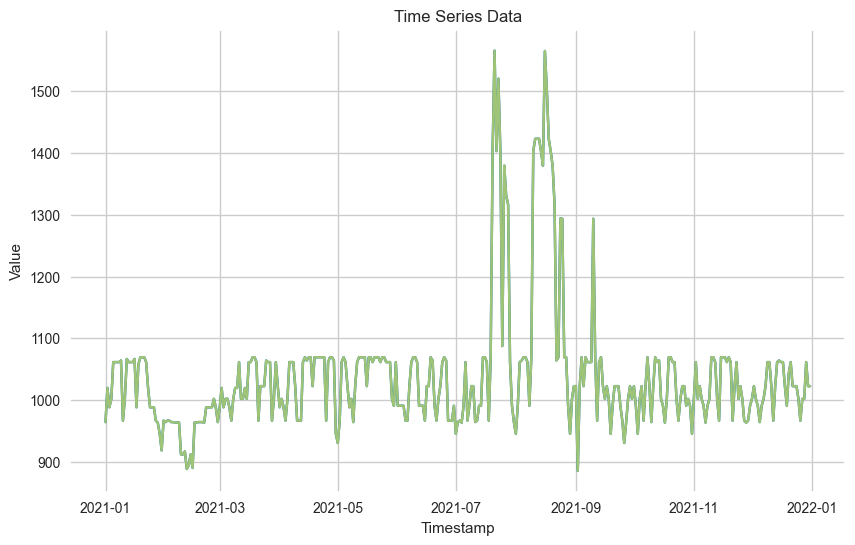

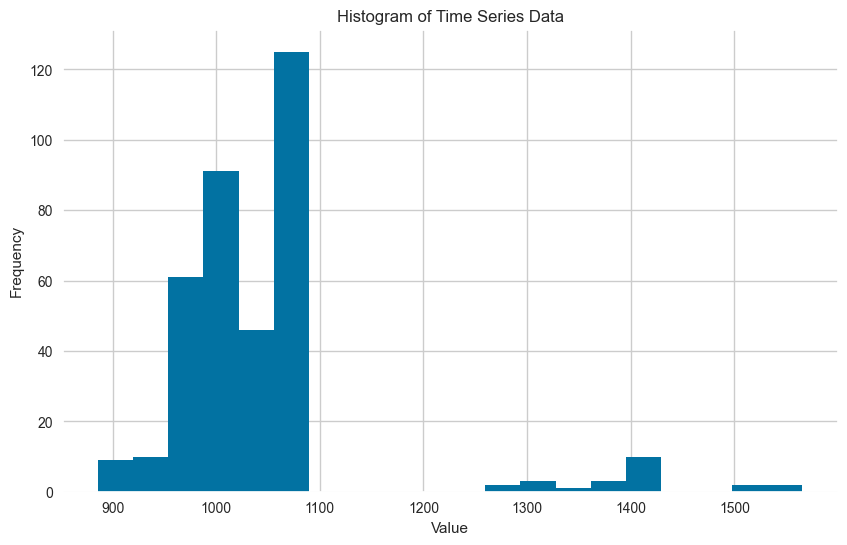

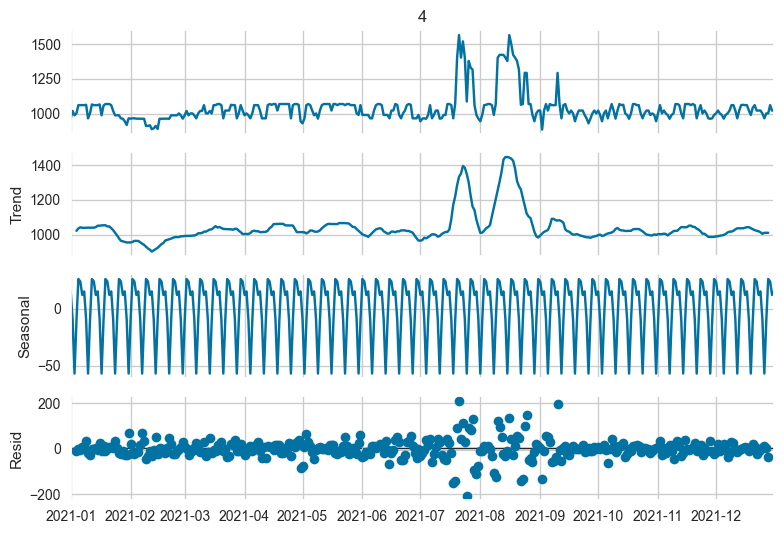

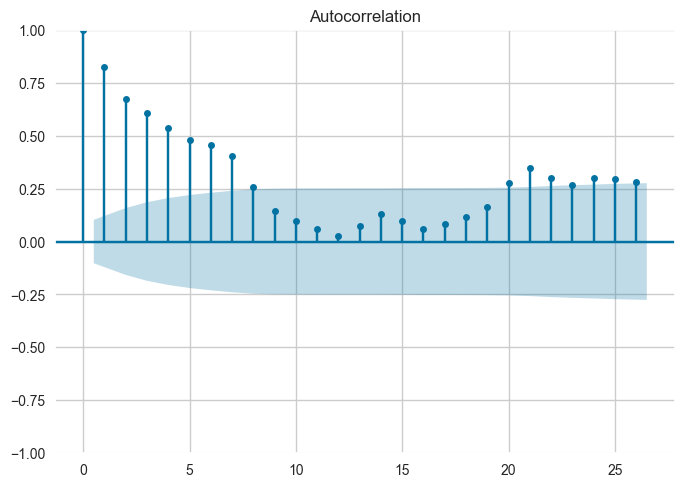

ADF Statistic: -2.784658019592205
p-value: 0.06049889940422127
Critical Values:
1% : -3.44911857009962
5% : -2.8698097654570507
10% : -2.5711757061225153


In [66]:
data=pd.read_csv(r"D:\TS\Gia SMP va SMPcap 2021(Giá thị trường SMP) (1).csv", encoding="latin-1", sep =';')
selected_columns = ['Date', '3', '4']
data = data[selected_columns]

# Hiển thị các dòng đầu tiên của DataFrame để đảm bảo rằng dữ liệu đã được chọn đúng
print(data.head())

data['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Đặt cột thời gian làm chỉ số (index) của DataFrame
data.set_index('Date', inplace=True)

# Biểu đồ đường (line plot) của dữ liệu thời gian
plt.figure(figsize=(10, 6))
plt.plot(data)
plt.title('Time Series Data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.show()

# Biểu đồ histogram của dữ liệu
plt.figure(figsize=(10, 6))
plt.hist(data['4'], bins=20)  # Thay 'column_name' bằng tên cột bạn quan tâm
plt.title('Histogram of Time Series Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Biểu đồ decompose để phân tích thành phần mùa vụ
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['4'], model='additive')
decomposition.plot()
plt.show()

# Kiểm tra tự tương quan (autocorrelation plot)
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['4'])
plt.show()

# Kiểm tra tính đồng nhất bằng Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['4'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, ':', value)

# Mô Hình Gaussian


In [75]:
df=pd.read_csv(r"D:\TS\Gia SMP va SMPcap 2021(Giá thị trường SMP) (1).csv", encoding="latin-1", sep =';')
feats= ['3','4']

In [76]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]))


In [77]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [78]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
print(pp)
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp # creating new dataframe columns of probabilites
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

[[8.33724771e-04 9.99152361e-01 1.99274485e-19 ... 1.71644099e-06
  1.71885364e-09 1.56755465e-12]
 [1.30043637e-03 9.98257232e-01 3.36161248e-04 ... 3.25318179e-06
  3.26161098e-09 2.97451757e-12]
 [7.47250648e-04 9.99229020e-01 1.43387168e-11 ... 1.67904828e-06
  1.68230570e-09 1.53422471e-12]
 ...
 [4.54451652e-04 4.84893292e-02 9.50902555e-01 ... 1.29660514e-06
  1.30098661e-09 1.18647227e-12]
 [1.42361351e-03 9.97341658e-01 1.10717655e-03 ... 3.59553425e-06
  3.60505789e-09 3.28773383e-12]
 [1.42361351e-03 9.97341658e-01 1.10717655e-03 ... 3.59553425e-06
  3.60505789e-09 3.28773383e-12]]


In [79]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000222868
[400]	valid_0's multi_logloss: 0.000222868
[200]	valid_0's multi_logloss: 0.000153552
[400]	valid_0's multi_logloss: 0.000153552
[200]	valid_0's multi_logloss: 0.00014931
[400]	valid_0's multi_logloss: 0.00014931
[200]	valid_0's multi_logloss: 0.000155099
[400]	valid_0's multi_logloss: 0.000155099
[200]	valid_0's multi_logloss: 0.000154836
[400]	valid_0's multi_logloss: 0.000154836
[200]	valid_0's multi_logloss: 0.000153665
[400]	valid_0's multi_logloss: 0.000153665
[200]	valid_0's multi_logloss: 0.000155014
[400]	valid_0's multi_logloss: 0.000155014
[200]	valid_0's multi_logloss: 8.85075e-06
[400]	valid_0's multi_logloss: 8.75466e-06
[600]	valid_0's multi_logloss: 8.69075e-06
[800]	valid_0's multi_logloss: 8.64542e-06
[1000]	valid_0's multi_logloss: 8.61163e-06
[1200]	valid_0's multi_logloss: 8.58551e-06
[1400]	valid_0's multi_logloss: 8.56471e-06
[1600]	valid_0's multi_logloss: 8.54777e-06
[1800]	valid_0's multi_logloss: 8.53372e-06
[2000]	v

In [81]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

Text(0.5, 1.0, 'Before clustering')

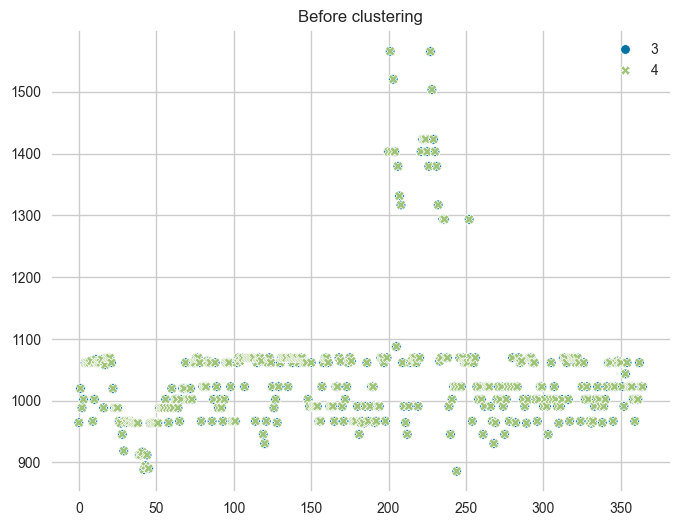

In [82]:
labels=np.argmax(lgb_preds,axis=1)
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o')
ax.set_title("Before clustering")

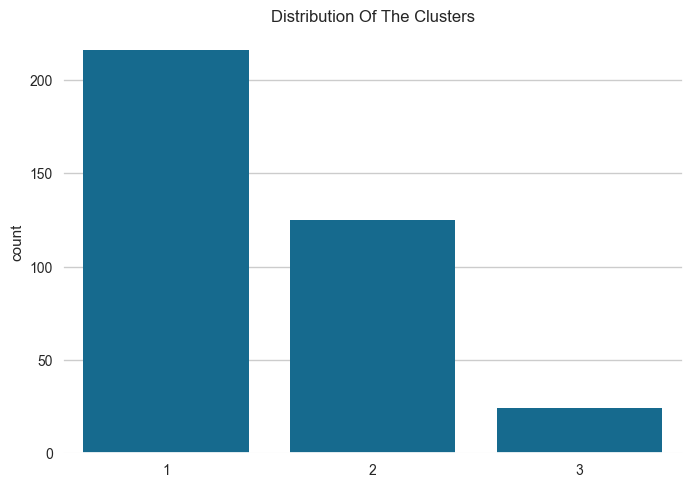

In [83]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

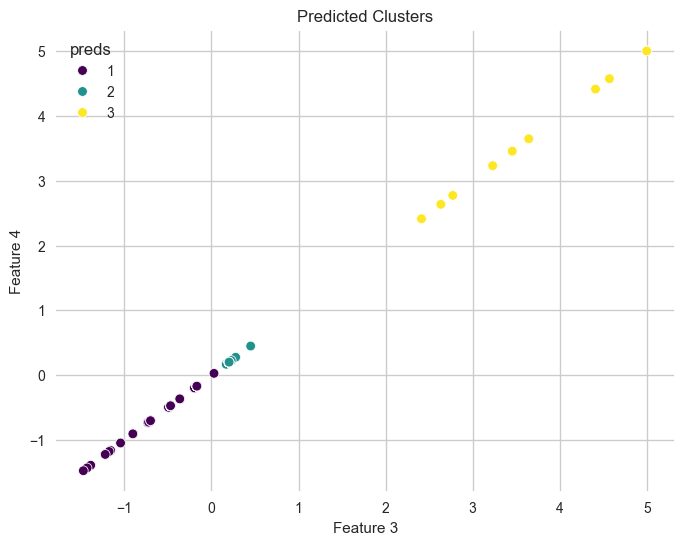

In [84]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_new['3'], y=df_new['4'], hue=df_new['preds'], palette='viridis', legend='full')
plt.title('Predicted Clusters')
plt.xlabel('Feature 3')
plt.ylabel('Feature 4')
plt.show()

# Mô hình ARIMA


c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



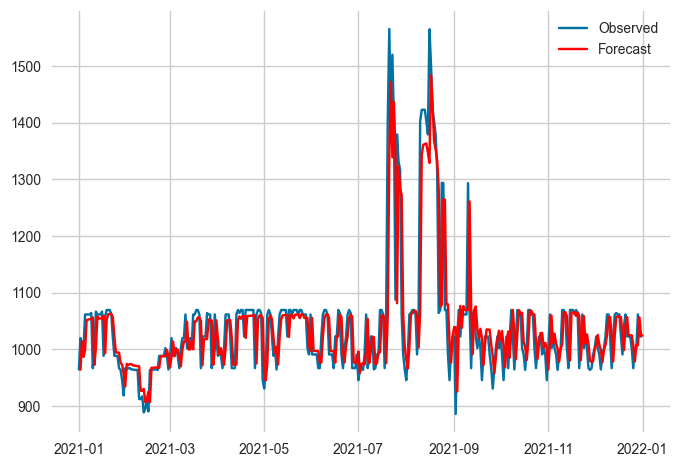

                               SARIMAX Results                                
Dep. Variable:                      4   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2003.606
Date:                Tue, 14 May 2024   AIC                           4013.212
Time:                        11:48:05   BIC                           4024.903
Sample:                    01-01-2021   HQIC                          4017.859
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8109      0.024     33.986      0.000       0.764       0.858
ma.L1         -0.9835      0.008   -120.703      0.000      -1.000      -0.968
sigma2      3522.9837    106.395     33.112      0.0

In [71]:
from statsmodels.tsa.arima.model import ARIMA


# Hiển thị kết quả dự báo
p, d, q = 1, 1, 1  # Thay đổi các giá trị này cho phù hợp
model = ARIMA(data['4'], order=(p, d, q))
result = model.fit()

# Hiển thị kết quả dự báo
forecast = result.predict(start=1, end=365, dynamic=False)  # Thay đổi giá trị start và end cho phù hợp
plt.plot(data['4'], label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Đánh giá mô hình
print(result.summary())